In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy.linalg as spl
import matplotlib.pyplot as plt
from tqdm import tqdm

import lstd
import test_utils
import trajgen

## I. Toy environments

In [3]:
p = 5
q = 3
Q, R = np.eye(p), np.eye(q)
sigma = 0.1

In [4]:
A, B = test_utils.random_env(p, q, Anorm=1.05)
Pstar = spl.solve_discrete_are(A, B, Q, R)
Kstar = -np.linalg.pinv(B.T @ Pstar @ B + R) @ (B.T @ Pstar @ A)

In [5]:
num_trajs = 10000
T = 10
xtrajs, utrajs, rtrajs = [], [], []
ctrl = test_utils.random_controller(q)
for _ in range(num_trajs):
    xtraj, utraj, rtraj = test_utils.sample_traj(A, B, Q, R, ctrl, T, sigma=sigma)
    xtrajs.append(xtraj)
    utrajs.append(utraj)
    rtrajs.append(rtraj)
traj = lstd.construct_traj_list(xtrajs, utrajs, rtrajs)

### I-a. Policy evaluation

In [ ]:
# Solve for a time-varying controller using value iteration
Pvi, Kvi = test_utils.lqr_vi(A, B, Q, R, 100, 0.99)
# Evaluate controller Kstar
Pxuhat, Pxhat = lstd.evaluate(traj, Kstar, 0.99, sigma=sigma)
test_utils.relerr(Pstar, Pxhat)

### I-b. Policy Iteration

In [7]:
K0 = np.random.random((q, p))
K, P = lstd.lspi(traj, 0.99, sigma=sigma, show_progress=False)

In [8]:
Tsim = 20
ctrl = test_utils.linear_feedback_controller(K)
ctrlopt = test_utils.linear_feedback_controller(Kstar)
xtraj, utraj, rtraj = test_utils.sample_traj(A, B, Q, R, ctrl, Tsim, sigma=0)
xopt, uopt, ropt = test_utils.sample_traj(A, B, Q, R, ctrlopt, Tsim, x0=xtraj[0], sigma=0)

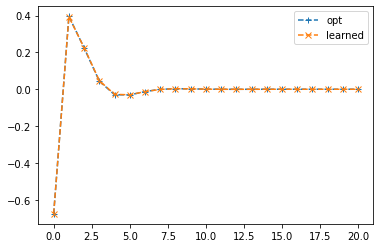

In [9]:
ind = 0
plt.plot(np.arange(Tsim+1), xopt[:, ind], '+--', label='opt')
plt.plot(np.arange(Tsim+1), xtraj[:, ind], 'x--', label='learned')
plt.legend()

## II. Tracking 2D min-snap trajectories on random linear dynamics

In [7]:
p = 2
q = 2
sigma = 0
A, B = test_utils.random_env(p, q, Anorm=0.99)
Q, R = 100 * np.eye(p), np.eye(q)
Tref = 10
# Construct augmented system for tracking
At, Bt, Qt, Rt = lstd.nominal_to_tracking(A, B, Q, R, Tref)

In [24]:
# Solve for a static tracking controller by directly solving DARE
Pstar = spl.solve_discrete_are(At, Bt, Qt, Rt)
Kstar = -np.linalg.pinv(Bt.T @ Pstar @ Bt + Rt) @ (Bt.T @ Pstar @ At)
static_opt_ctrl = test_utils.linear_feedback_controller(Kstar)
# Solve for dynamic tracking controller with VI
Pvi, Kvi = test_utils.lqr_vi(At, Bt, Qt, Rt, Tref)

### II-a Train a tracking controller

In [10]:
# Collect trajectory
ctrl = test_utils.random_controller(q)
num_trajs = 500
T = Tref
xtrajs, utrajs, rtrajs = [], [], []
for _ in range(num_trajs):
    # Sample a reference trajectory
    #ref = test_utils.sample_ref_traj(p, T, order=8).flatten(order='F')
    ref = np.random.randn(p*(T+1))
    d0 = np.concatenate([np.zeros(p), ref])
    # Collect trajectory using random tracking controller
    xtraj, utraj, rtraj = test_utils.sample_traj(At, Bt, Qt, Rt, ctrl, T, d0, sigma=sigma)
    xtrajs.append(xtraj)
    utrajs.append(utraj)
    rtrajs.append(rtraj)
traj = lstd.construct_traj_list(xtrajs, utrajs, rtrajs)

In [11]:
# Train a tracking controller
K0 = np.random.random((q, p))
K, P = lstd.lspi(traj, 0.99, max_iter=200, sigma=sigma)
learned_ctrl = test_utils.linear_feedback_controller(K)

  2%|██▌                                                                                                                                                                           | 3/200 [00:04<04:50,  1.47s/it]


### II-b Test tracking performance

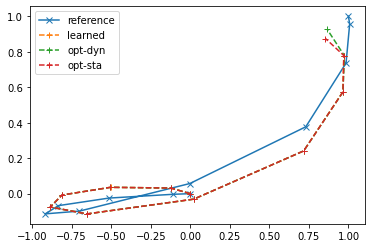

In [36]:
# Spline trajectory
x_waypoints = [0, np.random.randn(), np.random.randn(), 1]
y_waypoints = [0, np.random.randn(), np.random.randn(), 1]
ts = [0, 0.33, 0.66, 1]
order = 7

ref = np.vstack([trajgen.min_jerk(x_waypoints, ts, order, Tref)[1],
                 trajgen.min_jerk(y_waypoints, ts, order, Tref)[1]])
ref = ref.flatten(order='F')

d0 = np.concatenate([np.zeros(p), ref])
xtraj, utraj, rtraj = test_utils.sample_traj(At, Bt, Qt, Rt, learned_ctrl, Tref, d0, sigma=0)
xopt, uopt, ropt = test_utils.sample_traj(At, Bt, Qt, Rt, static_opt_ctrl, Tref, d0, sigma=0)
vi_ctrlr = test_utils.TVcontroller(Kvi[:])
xvi, uvi, rvi = test_utils.sample_traj(At, Bt, Qt, Rt, vi_ctrlr.ctrl, Tref, d0, sigma=0)

if p == 2:
    # Planar
    plt.plot(ref[0::2], ref[1::2], 'x-', label='reference')
    plt.plot(xtraj[:-1,0], xtraj[:-1, 1], '+--', label='learned')
    plt.plot(xvi[:,0], xvi[:, 1], '+--', label='opt-dyn')
    plt.plot(xopt[:,0], xopt[:, 1], '+--', label='opt-sta')
    plt.legend()

## III. Trajectory generation with dynamic regularization (1D)

In [6]:
p = 1
q = 1
sigma = 0
A, B = test_utils.random_env(p, q, Anorm=0.99)
Q, R = 1 * np.eye(p), np.eye(q)
Tref = 15
# Construct augmented system for tracking
At, Bt, Qt, Rt = lstd.nominal_to_tracking(A, B, Q, R, Tref)
# Solve for a static tracking controller by directly solving DARE
Pstar = spl.solve_discrete_are(At, Bt, Qt, Rt)
Kstar = -np.linalg.pinv(Bt.T @ Pstar @ Bt + Rt) @ (Bt.T @ Pstar @ At)
static_opt_ctrl = test_utils.linear_feedback_controller(Kstar)
# Solve for dynamic tracking controller with VI
Pvi, Kvi = test_utils.lqr_vi(At, Bt, Qt, Rt, Tref)

In [7]:
# Ref traj specifications
waypoints = [0, np.random.randn(), np.random.randn(), 1]
ts = [0, 0.33, 0.66, 1]

In [8]:
# Collect trajectory
ctrl = test_utils.random_controller(q)
num_trajs = 5000
T = Tref
xtrajs, utrajs, rtrajs = [], [], []
for _ in range(num_trajs):
    # Sample a reference trajectory
    #ref = test_utils.sample_ref_traj(p, T, order=8).flatten(order='F')
    #ref = trajgen.min_jerk(waypoints, ts, order, Tref)[1]
    ref = np.random.randn(p*(T+2))
    # Collect trajectory using random tracking controller
    xtraj, utraj, rtraj = test_utils.sample_traj(At, Bt, Qt, Rt, ctrl, T, ref, sigma=sigma)
    xtrajs.append(xtraj)
    utrajs.append(utraj)
    rtrajs.append(rtraj)
traj = lstd.construct_traj_list(xtrajs, utrajs, rtrajs)

# Train a tracking controller
K0 = np.random.random((q, p))
K, P = lstd.lspi(traj, 0.99, max_iter=50, sigma=sigma)
learned_ctrl = test_utils.linear_feedback_controller(K)

  8%|██████████████                                                                                                                                                                 | 4/50 [01:07<12:55, 16.86s/it]


In [9]:
test_utils.relerr(Pstar, P)

0.05960660633660388

[[ 1.00000000e+00 -2.80110725e-13  1.48093852e-14 -4.60537627e+02
   1.39035558e+03  6.73774658e+02 -3.90504081e+03]
 [-5.09430190e+00  2.54089675e+01 -1.51007792e-12 -2.89965027e+02
   4.77590994e+02  1.37366663e+02 -4.18004438e+02]
 [-1.32514348e+02  4.57923210e+02 -3.84111724e+02 -1.61183729e+02
   2.11704652e+02  1.08058819e+02 -9.88768790e+01]]
jerk:  0.000,	 penalty: 4.718
[[ 9.99999625e-01 -3.92781466e-08 -4.63759591e-09 -3.26608181e+02
  -8.23510420e+02  9.79774494e+03 -1.49508718e+04]
 [-7.51349397e+00  3.52757566e+01  8.76199345e-03 -4.52731836e+02
   1.27479172e+03 -1.26608802e+03  3.94909756e+02]
 [-1.42851944e+02  5.54051774e+02 -4.76658083e+02 -6.73216084e+02
   1.49685817e+03 -9.74582959e+02  2.17399128e+02]]
jerk:  0.000,	 penalty: 3.995
[[ 9.99999667e-01 -3.49432200e-08 -4.15907070e-09 -2.88880492e+02
  -1.14631664e+03  1.07223634e+04 -1.58383301e+04]
 [-7.61524809e+00  3.62959759e+01  8.39764492e-01 -4.84837780e+02
   1.38586303e+03 -1.41386905e+03  4.64215179e+02]
 [

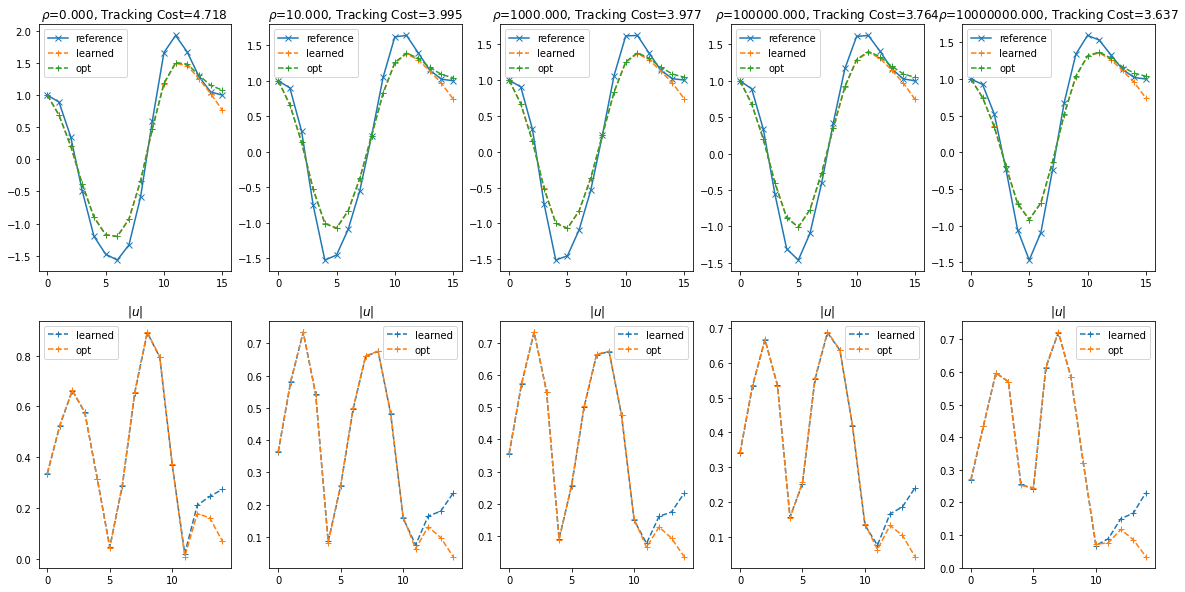

In [24]:
# Spline trajectory
#waypoints = [1, np.random.randn(), np.random.randn(), 1]
rhos = np.concatenate([[0], np.logspace(1, 7, 4)])

plt.figure(figsize=(20, 10))
for i, rho in enumerate(rhos):
    ret = trajgen.min_jerk(waypoints, ts, 7, Tref, P=P, rho=rho)
    if ret is None:
        continue
    else:
        _, ref, tc = ret
    d0 = np.concatenate([[waypoints[0]], ref])
    xtraj, utraj, rtraj = test_utils.sample_traj(At, Bt, Qt, Rt, learned_ctrl, Tref, d0, sigma=0)
    xopt, uopt, ropt = test_utils.sample_traj(At, Bt, Qt, Rt, static_opt_ctrl, Tref, d0, sigma=0)
    vi_ctrlr = test_utils.TVcontroller(Kvi[:])
    xvi, uvi, rvi = test_utils.sample_traj(At, Bt, Qt, Rt, vi_ctrlr.ctrl, Tref, d0, sigma=0)

    plt.subplot(2, len(rhos), i+1)
    plt.plot(np.arange(Tref+1), ref, 'x-', label='reference')
    plt.plot(np.arange(Tref+1), xtraj[:,0], '+--', label='learned')
    plt.plot(np.arange(Tref+1), xvi[:,0], '+--', label='opt')
    plt.legend()
    plt.title(r'$\rho$={:.3f}, Tracking Cost={:.3f}'.format(rho, tc))
    
    plt.subplot(2, len(rhos), i+1+len(rhos))
    plt.plot(np.arange(Tref), np.abs(utraj)[:,0], '+--', label='learned')
    plt.plot(np.arange(Tref), np.abs(uvi)[:,0], '+--', label='opt')
    plt.legend()
    plt.title(r'$|u|$'.format(rho, tc))

jerk:  0.000,	 penalty: 4.163
jerk:  0.000,	 penalty: 4.163
jerk:  0.000,	 penalty: 4.256
jerk:  0.000,	 penalty: 4.354


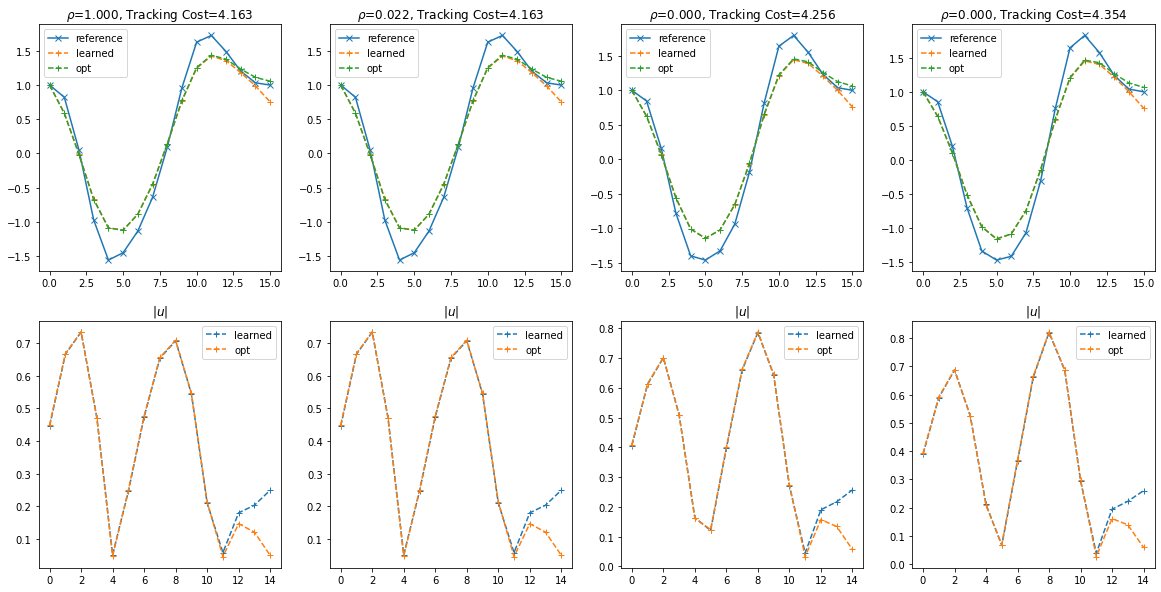

In [21]:
# Spline trajectory
rhos = np.logspace(0, -5, 4)

plt.figure(figsize=(20, 10))
for i, rho in enumerate(rhos):
    ret = trajgen.min_jerk(waypoints, ts, 6, Tref, P=P, rho=rho, threshold=rho)
    if ret is None:
        continue
    else:
        _, ref, tc = ret
    d0 = np.concatenate([[waypoints[0]], ref])
    xtraj, utraj, rtraj = test_utils.sample_traj(At, Bt, Qt, Rt, learned_ctrl, Tref, d0, sigma=0)
    xopt, uopt, ropt = test_utils.sample_traj(At, Bt, Qt, Rt, static_opt_ctrl, Tref, d0, sigma=0)
    vi_ctrlr = test_utils.TVcontroller(Kvi[:])
    xvi, uvi, rvi = test_utils.sample_traj(At, Bt, Qt, Rt, vi_ctrlr.ctrl, Tref, d0, sigma=0)

    plt.subplot(2, len(rhos), i+1)
    plt.plot(np.arange(Tref+1), ref, 'x-', label='reference')
    plt.plot(np.arange(Tref+1), xtraj[:,0], '+--', label='learned')
    plt.plot(np.arange(Tref+1), xvi[:,0], '+--', label='opt')
    plt.legend()
    plt.title(r'$\rho$={:.3f}, Tracking Cost={:.3f}'.format(rho, tc))
    
    plt.subplot(2, len(rhos), i+1+len(rhos))
    plt.plot(np.arange(Tref), np.abs(utraj)[:,0], '+--', label='learned')
    plt.plot(np.arange(Tref), np.abs(uvi)[:,0], '+--', label='opt')
    plt.legend()
    plt.title(r'$|u|$'.format(rho, tc))

In [36]:
np.arange(2)

array([0, 1])

In [28]:
n = 5

In [70]:
trajgen.cost_matrix(7, 3, 1)

array([[4900.        , 3150.        , 1800.        ,  840.        ,
         252.        ,    0.        ,    0.        ,    0.        ],
       [3150.        , 2057.14285714, 1200.        ,  576.        ,
         180.        ,    0.        ,    0.        ,    0.        ],
       [1800.        , 1200.        ,  720.        ,  360.        ,
         120.        ,    0.        ,    0.        ,    0.        ],
       [ 840.        ,  576.        ,  360.        ,  192.        ,
          72.        ,    0.        ,    0.        ,    0.        ],
       [ 252.        ,  180.        ,  120.        ,   72.        ,
          36.        ,    0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    

In [57]:
cost_matrix(4, 2, 2)

array([[921.6, 288. ,  64. ,   0. ,   0. ],
       [288. ,  96. ,  24. ,   0. ,   0. ],
       [ 64. ,  24. ,   8. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ]])